In [1]:
import os
import pandas as pd

In [2]:
fns = os.listdir('../processed_data/adj_expression/')

In [3]:
fns2 = os.listdir('../processed_data/transposed_expression/')

In [4]:
for i, f in enumerate(fns2):
    df_exp = pd.read_csv('../processed_data/transposed_expression/' + f, index_col=0, nrows = 5)
    if i == 0:
        s0 = set(map(str, df_exp.columns))
    else:
        s0 = s0 & set(map(str, df_exp.columns))

In [5]:
#!/usr/bin/env python
import pandas
import sqlite3

connection = sqlite3.connect("../data/gwas_g2p/metaxcan_results_p/metaxcan_results_v1.5.db")

In [6]:
query = 'SELECT g.gene_name, m.zscore, m.n_snps_used, m.n_snps_model, p.tag as phenotype, t.tissue as tissue, g.gene ' 
query += ' FROM gene AS g INNER JOIN metaxcan_result AS m ON g.id = m.gene_id' 
query += ' INNER JOIN tissue AS t ON t.id = m.tissue_id  INNER JOIN pheno AS p ON p.id = m.pheno_id'

In [7]:
pi = pandas.read_sql_query(query, connection)

In [8]:
pi.shape

(15909571, 7)

In [9]:
res = {}
for key, item in pi.groupby('phenotype'):
    res[key] = [(un, um) for un, um in zip(item.n_snps_used, item.n_snps_model)]

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline
res_prop = {key:[float(v[0]) / float(v[1]) for v in item] for key, item in res.items()}


In [11]:
import numpy as np

tmp = sorted([(key, np.mean(item)) for key, item in res_prop.items()], key = lambda x: x[1], reverse=True)

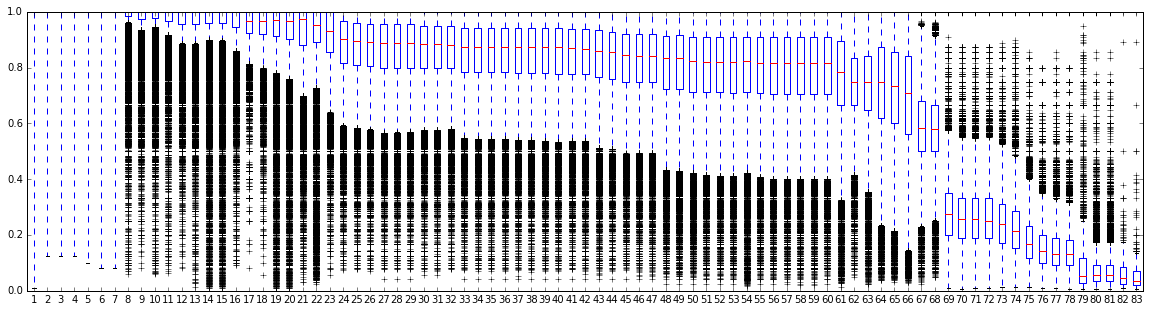

In [12]:
fig = plt.figure(figsize=(20, 5))
plt.boxplot([res_prop[k] for k, c in tmp])
plt.show()

In [13]:
tmp = sorted([(key, np.median(item)) for key, item in res_prop.items()], key = lambda x: x[1], reverse=True)

In [14]:
selected_phenotypes = set([k for k, c in tmp if c > 0.9])

In [15]:
pi = pi[pi.phenotype.apply(lambda x: x in selected_phenotypes)]

In [16]:
pi = pi[[(float(un) / float(um)) > 0.9 for un, um in zip(pi.n_snps_used, pi.n_snps_model)]]

In [20]:
id2tissue = sorted(set(pi.tissue))
id2gene = sorted(set(pi.gene))
id2phenotype = sorted(set(pi.phenotype))

tissue2id = {t:i for i, t in enumerate(id2tissue)}
phenotype2id = {t:i for i, t in enumerate(id2phenotype)}
gene2id = {t:i for i, t in enumerate(id2gene)}

In [23]:
import numpy as np

#mat = np.zeros((len(id2phenotype), len(id2gene)))
mat = np.zeros((len(id2phenotype), len(id2tissue), len(id2gene)))
ind_mat = np.zeros_like(mat)
for i, (z, g, t, p) in enumerate(zip(pi.zscore, pi.gene, pi.tissue, pi.phenotype)):
    mat[phenotype2id[p], tissue2id[t], gene2id[g]] = z
    ind_mat[phenotype2id[p], tissue2id[t], gene2id[g]] = 1

In [25]:
ind_mat.shape

(24, 45, 17826)

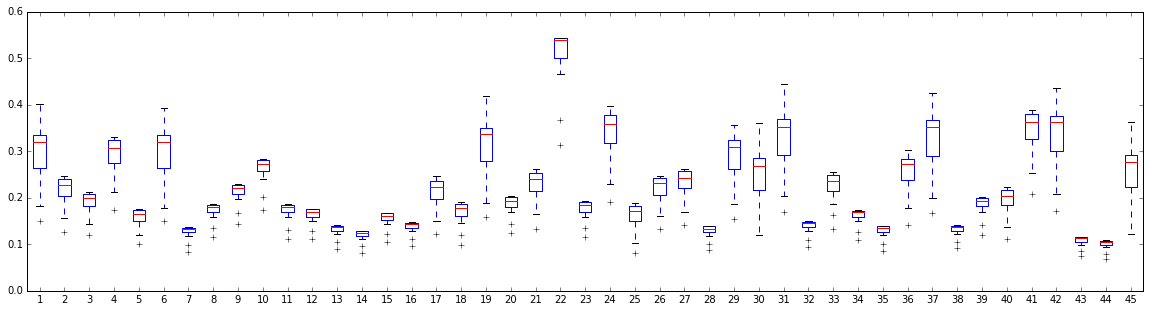

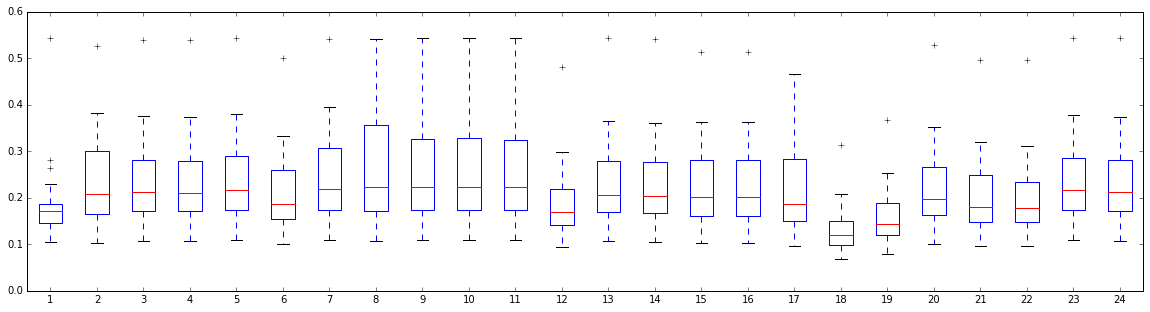

In [33]:
fig = plt.figure(figsize=(20, 5))
plt.boxplot(ind_mat.sum(axis = 2) / 17826.0)
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.boxplot(ind_mat.sum(axis = 2).T / 17826.0)
plt.show()

In [36]:
(ind_mat.sum(axis = 0) == 0).sum(axis = 1)

array([10578, 13379, 14041, 11884, 14685, 10756, 15397, 14501, 13749,
       12761, 14492, 14688, 15318, 15536, 14842, 15205, 13354, 14385,
       10288, 14207, 13097,  8116, 14369, 10656, 14386, 13376, 13108,
       15324, 11383, 11313,  9817, 15153, 13223, 14732, 15335, 12356,
       10161, 15311, 14224, 13791, 10824,  9974, 15768, 15887, 11242])

In [37]:
ind_mat.sum() / ind_mat.size

0.21757934727052869

In [38]:
len(id2gene)

17826

In [17]:
s1 = set(pi.gene)

In [18]:
len(s1 & set([s.split('.')[0] for s in s0]))

11900

In [39]:
s0 = set([s.split('.')[0] for s in s0])

In [44]:
np.sum(np.abs(pi[pi.gene.apply(lambda x: x not in s0)].zscore) > 5.0)

1279